In [1]:
from __future__ import annotations

import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

from seapopym.configuration.no_transport.configuration import NoTransportConfiguration
from seapopym.configuration.no_transport.parameter import (
    ForcingParameters,
    FunctionalGroups,
    KernelParameters,
    NoTransportParameters,
)
from seapopym.configuration.parameters.parameter_forcing import ForcingUnit
from seapopym.configuration.parameters.parameter_functional_group import (
    FunctionalGroupUnit,
    FunctionalGroupUnitMigratoryParameters,
    FunctionalGroupUnitRelationParameters,
)
from seapopym.logging.custom_logger import set_error
from seapopym.model.no_transport_model import NoTransportModel
from seapopym.standard.units import StandardUnitsLabels

set_error()
xr.set_options(keep_attrs=True)

In [2]:
WET_TO_CARBON = 1 / 11.9

## Observation data


In [3]:
bats_obs = xr.open_dataset("../data/phd/BATS/PROCESSED/BATS_zooplankton.nc").cf.sel(T=slice("2010", "2020"))
bats_obs.load()

<xarray.Dataset> Size: 131kB
Dimensions:              (latitude: 5, longitude: 6, day_phase: 2, time: 132,
                          depth: 3)
Coordinates:
  * latitude             (latitude) float64 40B 31.2 31.3 31.4 31.5 31.6
  * longitude            (longitude) float64 48B -64.3 -64.2 ... -63.6 -63.5
  * day_phase            (day_phase) <U5 40B 'night' 'day'
  * time                 (time) datetime64[ns] 1kB 2010-01-31 ... 2020-12-31
    quantile             float64 8B 0.975
  * depth                (depth) int32 12B 1 2 3
Data variables:
    zooplankton          (day_phase, time, latitude, longitude) float64 63kB ...
    zooplankton_epi      (time, latitude, longitude) float64 32kB nan ... nan
    zooplankton_migrant  (time, latitude, longitude) float64 32kB nan ... nan
    pelagic_layer_depth  (time, depth) float64 3kB 101.5 304.6 710.8 ... nan nan

## Forcing


In [4]:
path_forcing = "/Users/ash/Documents/Workspaces/Data/phd/CMEMS/hot_position/cmems_mod_glo_bgc_0_083deg.zarr"

forcing = xr.open_zarr(path_forcing)
forcing["T"].attrs["units"] = StandardUnitsLabels.temperature.units
forcing = forcing.cf.sel(Y=bats_obs.cf["Y"], X=bats_obs.cf["X"], method="nearest").cf.sel(T=slice("2010", "2020"))
forcing = forcing.assign_coords(latitude=bats_obs.cf["latitude"], longitude=bats_obs.cf["longitude"])
forcing.load()

<xarray.Dataset> Size: 19MB
Dimensions:              (time: 3712, depth: 3, latitude: 5, longitude: 6)
Coordinates:
  * depth                (depth) int32 12B 1 2 3
  * time                 (time) datetime64[ns] 30kB 2010-01-01 ... 2020-02-29
  * latitude             (latitude) float64 40B 31.2 31.3 31.4 31.5 31.6
  * longitude            (longitude) float64 48B -64.3 -64.2 ... -63.6 -63.5
Data variables: (12/13)
    T                    (time, depth, latitude, longitude) float64 3MB 22.95...
    U                    (time, depth, latitude, longitude) float64 3MB 0.038...
    V                    (time, depth, latitude, longitude) float64 3MB -0.07...
    mnkc_epi             (time, latitude, longitude) float64 891kB 0.3516 ......
    mnkc_hmlmeso         (time, latitude, longitude) float64 891kB 0.8923 ......
    mnkc_lmeso           (time, latitude, longitude) float64 891kB 1.884 ... ...
    ...                   ...
    mnkc_mumeso          (time, latitude, longitude) float64 891kB 0.6948 ......
    mnkc_umeso           (time, latitude, longitude) float64 891kB 0.6326 ......
    npp                  (time, latitude, longitude) float64 891kB 343.1 ... ...
    pelagic_layer_depth  (time, depth, latitude, longitude) float64 3MB 110.6...
    zeu                  (time, latitude, longitude) float64 891kB 73.71 ... ...
    zooc                 (time, latitude, longitude) float64 891kB 0.3005 ......
Attributes: (12/13)
    Conventions:                      CF-1.7
    date_field:                       1998-01-01
    domain:                           global
    history:                          Created on 2022-09-28
    institution:                      CLS
    net_primary_production_model:     VGPM
    ...                               ...
    source:                           SEAPODYM-LMTL 3.0.0
    source_biogeochemical_variables:  OCEANCOLOUR_GLO_CHL_L4_REP_OBSERVATIONS...
    source_physical_variables:        GLOBAL_REANALYSIS_PHY_001_030 CMEMS pro...
    spatial_resolution:               0.083x0.083
    temporal_resolution:              1 day
    title:                            Global ocean low and mid trophic levels...

## Initial Conditions


In [5]:
initial_conditions = xr.open_dataset("./initial_conditions_notransport_zooplankton.zarr")
initial_conditions = initial_conditions.cf.sel(Y=bats_obs.cf["Y"], X=bats_obs.cf["X"], method="nearest")
initial_conditions = initial_conditions.assign_coords(
    latitude=bats_obs.cf["latitude"], longitude=bats_obs.cf["longitude"]
)
initial_conditions.load()

<xarray.Dataset> Size: 3kB
Dimensions:                       (cohort: 11, functional_group: 1,
                                   latitude: 5, longitude: 6)
Coordinates:
  * cohort                        (cohort) int64 88B 0 1 2 3 4 5 6 7 8 9 10
  * functional_group              (functional_group) int64 8B 0
    time                          datetime64[ns] 8B 2022-12-31
  * latitude                      (latitude) float64 40B 31.2 31.3 ... 31.5 31.6
  * longitude                     (longitude) float64 48B -64.3 -64.2 ... -63.5
Data variables:
    initial_condition_biomass     (functional_group, latitude, longitude) float64 240B ...
    initial_condition_production  (functional_group, latitude, longitude, cohort) float64 3kB ...

## Setup


In [7]:
forcing_parameter = ForcingParameters(
    temperature=ForcingUnit(forcing=forcing["T"], resolution=0.08333),
    primary_production=ForcingUnit(forcing=forcing["npp"], resolution=0.08333),
    initial_condition_biomass=ForcingUnit(forcing=initial_conditions["initial_condition_biomass"], resolution=0.08333),
    initial_condition_production=ForcingUnit(
        forcing=initial_conditions["initial_condition_production"], resolution=0.08333
    ),
)


def zoo_model_factory(
    forcing_parameter: ForcingParameters,
    day_layer: float = 1,
    night_layer: float = 1,
    tr_max: float = 10.38,
    tr_rate: float = -0.11,
    inv_lambda_max: float = 150,
    inv_lambda_rate: float = 0.15,
    energy_transfert: float = 0.1668,
):
    f_groups = FunctionalGroups(
        functional_groups=[
            FunctionalGroupUnit(
                name=f"D{day_layer}N{night_layer}",
                migratory_type=FunctionalGroupUnitMigratoryParameters(day_layer=day_layer, night_layer=night_layer),
                functional_type=FunctionalGroupUnitRelationParameters(
                    inv_lambda_max=inv_lambda_max,
                    inv_lambda_rate=inv_lambda_rate,
                    temperature_recruitment_rate=tr_rate,
                    cohorts_timesteps=[1] * np.ceil(tr_max).astype(int),
                    temperature_recruitment_max=tr_max,
                ),
                energy_transfert=energy_transfert,
            )
        ]
    )

    parameters = NoTransportParameters(
        functional_groups_parameters=f_groups,
        forcing_parameters=forcing_parameter,
        kernel_parameters=KernelParameters(compute_initial_conditions=True),
    )
    return NoTransportModel(configuration=NoTransportConfiguration(parameters))


def wrapper_zoo_model(x: np.ndarray):
    tr_max, tr_rate, inv_lambda_max, inv_lambda_rate = x.T

    # Then call the original model
    param = zoo_model_factory(
        forcing_parameter=forcing_parameter,
        tr_max=tr_max,
        tr_rate=tr_rate,
        inv_lambda_max=inv_lambda_max,
        inv_lambda_rate=inv_lambda_rate,
    )
    param.run()
    biomass_forcing = param.export_biomass()
    return biomass_forcing

## Run


In [9]:
wrapper_zoo_model(np.array([10.38, -0.11, 150, 0.15]))  # [0, :, 0, 0]

<xarray.DataArray <ForcingLabels.biomass: 'biomass'> (functional_group: 1,
                                                      time: 3712, latitude: 5,
                                                      longitude: 6)> Size: 891kB
array([[[[0.00020296, 0.00020296, 0.00020296, 0.00020296, 0.00020296,
          0.00020296],
         [0.00020296, 0.00020296, 0.00020296, 0.00020296, 0.00020296,
          0.00020296],
         [0.00020296, 0.00020296, 0.00020296, 0.00020296, 0.00020296,
          0.00020296],
         [0.00020296, 0.00020296, 0.00020296, 0.00020296, 0.00020296,
          0.00020296],
         [0.00020296, 0.00020296, 0.00020296, 0.00020296, 0.00020296,
          0.00020296]],

        [[0.00022032, 0.00022032, 0.00022032, 0.00022032, 0.00022032,
          0.00022032],
         [0.00022032, 0.00022032, 0.00022032, 0.00022032, 0.00022032,
          0.00022032],
         [0.00022032, 0.00022032, 0.00022032, 0.00022032, 0.00022032,
          0.00022032],
         [0.00022032, 0.00022032, 0.00022032, 0.00022032, 0.00022032,
          0.00022032],
         [0.00022032, 0.00022032, 0.00022032, 0.00022032, 0.00022032,
...
          0.00021806],
         [0.00021806, 0.00021806, 0.00021806, 0.00021806, 0.00021806,
          0.00021806],
         [0.00021806, 0.00021806, 0.00021806, 0.00021806, 0.00021806,
          0.00021806],
         [0.00021806, 0.00021806, 0.00021806, 0.00021806, 0.00021806,
          0.00021806],
         [0.00021806, 0.00021806, 0.00021806, 0.00021806, 0.00021806,
          0.00021806]],

        [[0.00021284, 0.00021284, 0.00021284, 0.00021284, 0.00021284,
          0.00021284],
         [0.00021284, 0.00021284, 0.00021284, 0.00021284, 0.00021284,
          0.00021284],
         [0.00021284, 0.00021284, 0.00021284, 0.00021284, 0.00021284,
          0.00021284],
         [0.00021284, 0.00021284, 0.00021284, 0.00021284, 0.00021284,
          0.00021284],
         [0.00021284, 0.00021284, 0.00021284, 0.00021284, 0.00021284,
          0.00021284]]]])
Coordinates:
  * functional_group  (functional_group) int64 8B 0
  * time              (time) datetime64[ns] 30kB 2010-01-01 ... 2020-02-29
  * latitude          (latitude) float64 40B 31.2 31.3 31.4 31.5 31.6
  * longitude         (longitude) float64 48B -64.3 -64.2 -64.1 ... -63.6 -63.5
Attributes:
    long_name:    biomass
    units:        kilogram / meter ** 2
    description:  The biomass of the recruited individuals.

In [10]:
forcing = forcing.cf.mean(["Y", "X"])
bats_obs = bats_obs.cf.mean(["Y", "X"])

In [13]:
bats_obs

<xarray.Dataset> Size: 9kB
Dimensions:              (day_phase: 2, time: 132, depth: 3)
Coordinates:
  * day_phase            (day_phase) <U5 40B 'night' 'day'
  * time                 (time) datetime64[ns] 1kB 2010-01-31 ... 2020-12-31
    quantile             float64 8B 0.975
  * depth                (depth) int32 12B 1 2 3
Data variables:
    zooplankton          (day_phase, time) float64 2kB 4.681 4.867 ... 1.035
    zooplankton_epi      (time) float64 1kB 1.852 1.847 2.687 ... 0.805 1.035
    zooplankton_migrant  (time) float64 1kB 1.373 1.582 0.5293 ... 0.66 1.155
    pelagic_layer_depth  (time, depth) float64 3kB 101.5 304.6 710.8 ... nan nan

In [18]:
bats_obs["pelagic_layer_depth"]

<xarray.DataArray 'pelagic_layer_depth' (time: 132, depth: 3)> Size: 3kB
array([[ 101.54270222,  304.62891334,  710.79960336],
       [  99.32029542,  297.96213687,  695.24425485],
       [  96.72898609,  290.18618518,  677.10047248],
       [ 105.69765724,  317.09234135,  739.8817239 ],
       [ 127.54546087,  382.63490278,  888.96914112],
       [ 152.5354804 ,  457.60654115,  998.91774961],
       [ 152.34370613,  457.02998498,  998.51192985],
       [ 156.05552531,  468.16692529,  999.7521546 ],
       [ 130.88523156,  392.65721227,  900.93260507],
       [ 122.41796429,  367.2546857 ,  856.92724163],
       [ 115.76379733,  347.29189288,  810.34702432],
       [ 109.78183994,  329.3455366 ,  768.47320708],
       [  98.42851126,  295.28591088,  688.99975392],
       [  96.34084707,  289.02201211,  674.38524739],
       [  94.05534605,  282.16556992,  658.38611465],
       [ 109.08310853,  327.24921074,  763.58162994],
       [ 141.37563605,  424.12666164,  967.62081736],
       [ 144.90884995,  434.72801014,  986.76075468],
       [ 146.5408395 ,  439.62189782,  992.1295609 ],
       [ 149.12393317,  447.37113727,  990.25652316],
...
       [ 147.2928982 ,  441.87703459,  978.61017291],
       [ 153.41333213,  460.24114167,  999.62664381],
       [ 155.84807517,  467.54494905,  999.82572526],
       [ 151.09498659,  453.28589117,  998.42263067],
       [ 153.62580708,  460.8756453 ,  999.76468522],
       [ 148.99324097,  446.97825693,  995.90174432],
       [ 132.05395831,  396.1603138 ,  923.19295685],
       [ 116.71074367,  350.1342849 ,  816.97880367],
       [ 115.22543121,  345.67509093,  806.57457668],
       [ 110.49292039,  331.47662428,  773.44683179],
       [          nan,           nan,           nan],
       [          nan,           nan,           nan],
       [          nan,           nan,           nan],
       [          nan,           nan,           nan],
       [          nan,           nan,           nan],
       [          nan,           nan,           nan],
       [          nan,           nan,           nan],
       [          nan,           nan,           nan],
       [          nan,           nan,           nan],
       [          nan,           nan,           nan]])
Coordinates:
  * time      (time) datetime64[ns] 1kB 2010-01-31 2010-02-28 ... 2020-12-31
    quantile  float64 8B 0.975
  * depth     (depth) int32 12B 1 2 3
Attributes:
    standard_name:  sea_water_pelagic_layer_bottom_depth
    units:          m

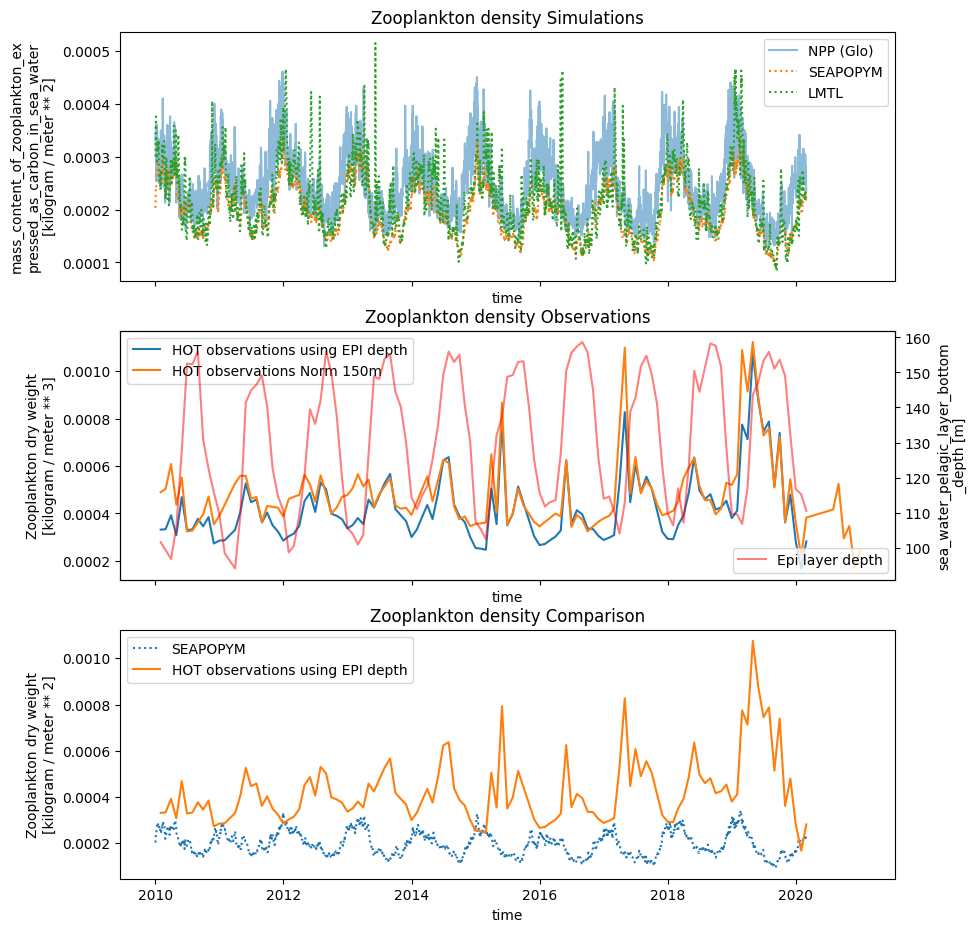

In [22]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 11), sharex=True)

# AXE 1 --------------------------------------

# NPP
forcing["npp"].pint.quantify().pint.to("kg/ day / m2").pint.dequantify().plot(ax=ax1, alpha=0.5, label="NPP (Glo)")

# SEAPOPYM
res_model = wrapper_zoo_model(np.array([10.38, -0.11, 150, 0.15]))[0, :, 0, 0]
res_model.cf.dropna("T").plot(ax=ax1, label="SEAPOPYM", linestyle=":", linewidth=1.5)

# LMTL
forcing["zooc"].pint.quantify().pint.to("kg/m2").plot(ax=ax1, label="LMTL", linestyle=":", linewidth=1.5)

ax1.legend()
ax1.set_title("")

# AXE é --------------------------------------

# HOT
with xr.set_options(keep_attrs=True):
    obs = bats_obs["zooplankton"].mean("day_phase")
    obs = obs.pint.quantify().pint.to("kg/m3")  # .pint.dequantify()
    obs_norm = obs * 150
    obs = obs * bats_obs["pelagic_layer_depth"][:, 0].pint.quantify()
obs.plot(ax=ax2, label="HOT observations using EPI depth")
obs_norm.plot(ax=ax2, label="HOT observations Norm 150m")
ax2.set_title("")
ax2.legend()

# Je veux afficher sur un autre axe
ax2 = ax2.twinx()
bats_obs["pelagic_layer_depth"][:, 0].plot(ax=ax2, color="red", label="Epi layer depth", alpha=0.5)
ax2.legend()
ax2.set_title("")

# AXE 3 --------------------------------------

# SEAPOPYM
res_model.cf.dropna("T").plot(ax=ax3, label="SEAPOPYM", linestyle=":", linewidth=1.5)
obs.plot(ax=ax3, label="HOT observations using EPI depth")
ax3.legend()

# END --------------------------------------

# more space between ax1 and ax2
plt.subplots_adjust(hspace=0.2)
ax1.set_title("Zooplankton density Simulations")
ax2.set_title("Zooplankton density Observations")
ax3.set_title("Zooplankton density Comparison")

plt.show()

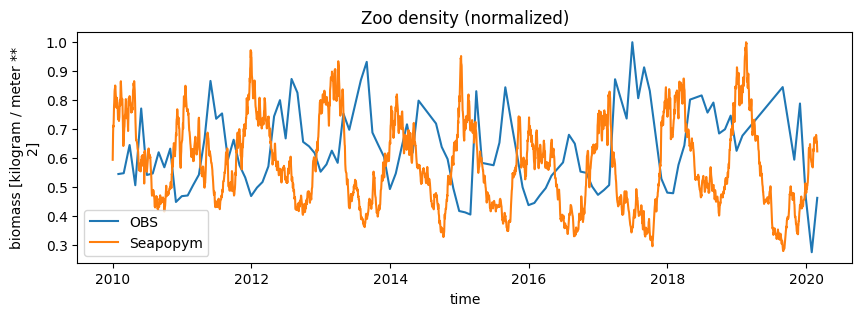

In [23]:
plt.figure(figsize=(10, 3))
no_out_obs = obs.where(obs < obs.quantile(0.9)).interpolate_na("time")
(no_out_obs / no_out_obs.max()).plot(label="OBS")
(res_model / res_model.max()).plot(label="Seapopym")
plt.title("Zoo density (normalized)")
plt.legend()
plt.show()

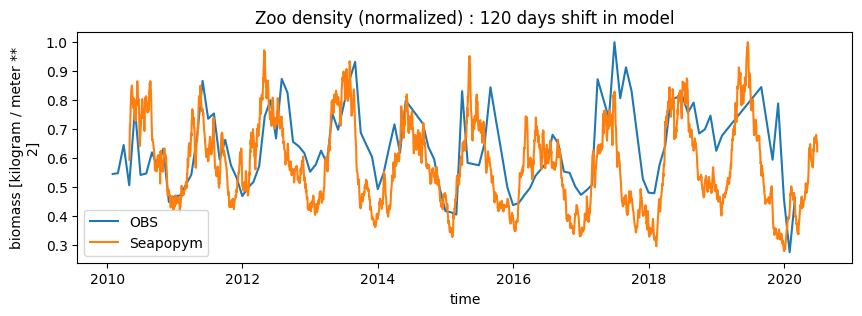

In [24]:
res_model_rolled = res_model.assign_coords(time=res_model.cf["T"] + np.timedelta64(120, "D"))

plt.figure(figsize=(10, 3))
no_out_obs = obs.where(obs < obs.quantile(0.9)).interpolate_na("time")
(no_out_obs / no_out_obs.max()).plot(label="OBS")
(res_model_rolled / res_model_rolled.max()).plot(label="Seapopym")
plt.title("Zoo density (normalized) : 120 days shift in model")
plt.legend()
plt.show()